In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.rcParams["figure.figsize"] = (10, 4)

# Class ID → Annotation mapping (from brief)
id_to_label = {
    0: "Undetermined",
    1: "N",   # Normal
    2: "L",   # LBBB
    3: "R",   # RBBB
    4: "V",   # Premature ventricular contraction
    5: "A",   # Atrial premature beat
    6: "F",   # Fusion ventricular normal beat
    7: "f",   # Fusion of paced and normal beat
    8: "/",   # Paced beat
}

In [2]:
# CHANGE THESE PATHS / NAMES IF NEEDED
train_path = "train_beats.csv"
test_path  = "test_beats.csv"

train_df = pd.read_csv(train_path, header=None)
test_df  = pd.read_csv(test_path, header=None)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
train_df.head()


Train shape: (30992, 277)
Test shape : (37442, 277)


,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,2.016945,1.344029,1.344029,1.273195,1.344029,1.166946,1.060696,1.025279,1.025279,0.989862,...,0.175280,0.281530,0.210697,0.175280,0.139863,0.281530,0.210697,0.352363,7.0,104.0
1,1.956627,0.034137,0.009170,0.059105,-0.040765,-0.015798,0.034137,0.084072,0.009170,-0.015798,...,-1.014493,-1.014493,-1.014493,-0.989526,-0.914624,-0.964559,-1.014493,-1.089396,2.0,111.0
2,0.435271,0.725131,0.712529,0.750337,0.788144,0.825952,0.863760,0.838555,0.788144,0.762939,...,-0.308283,-0.220065,-0.157051,-0.081436,-0.043628,0.031988,0.120206,0.284040,6.0,208.0
3,0.230134,-0.199004,-0.215509,-0.215509,-0.221011,-0.221011,-0.226513,-0.243018,-0.254022,-0.232015,...,1.016888,1.055400,1.071905,1.060902,1.060902,1.049898,1.055400,1.060902,8.0,107.0
4,3.406234,-0.103728,-0.121545,-0.050277,0.038809,0.110077,0.145711,0.110077,0.110077,0.038809,...,-0.228447,-0.228447,-0.121545,-0.192813,-0.228447,-0.264081,-0.264081,-0.264081,1.0,116.0


In [3]:
def split_xy(df):
    X = df.iloc[:, :-2].values     # ECG samples
    y = df.iloc[:, -2].values      # class ID
    patient_id = df.iloc[:, -1].values  # patient number
    return X, y, patient_id

X_train, y_train, pid_train = split_xy(train_df)
X_test,  y_test,  pid_test  = split_xy(test_df)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique labels in train:", np.unique(y_train))


X_train shape: (30992, 275)
y_train shape: (30992,)
Unique labels in train: [1. 2. 3. 4. 5. 6. 7. 8.]


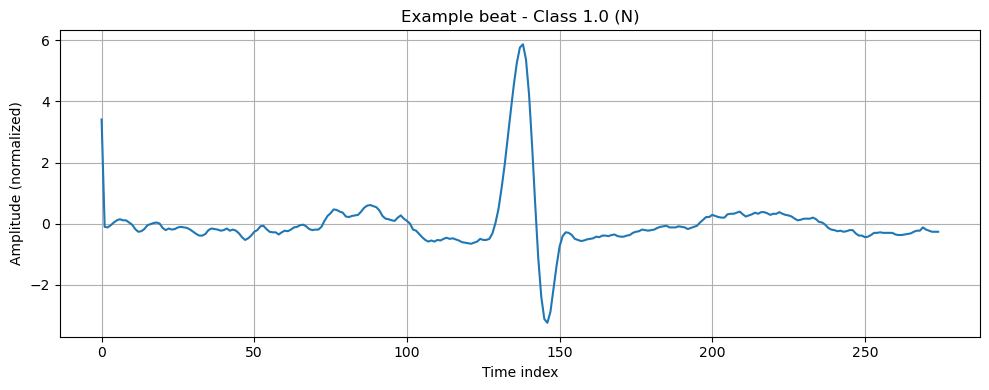

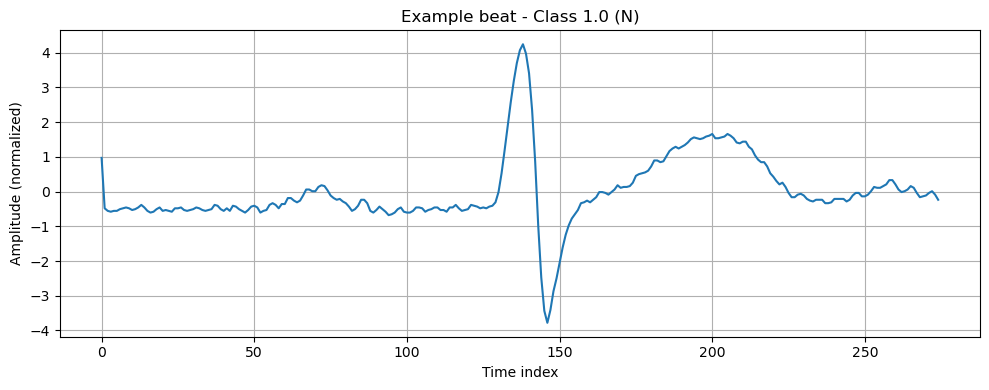

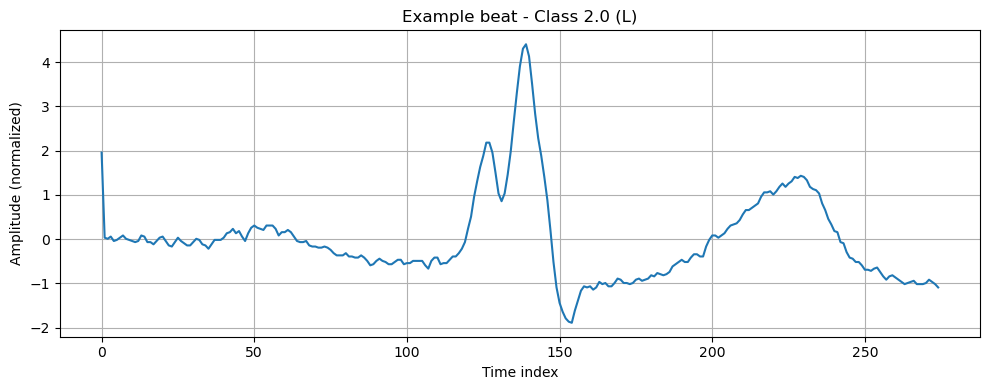

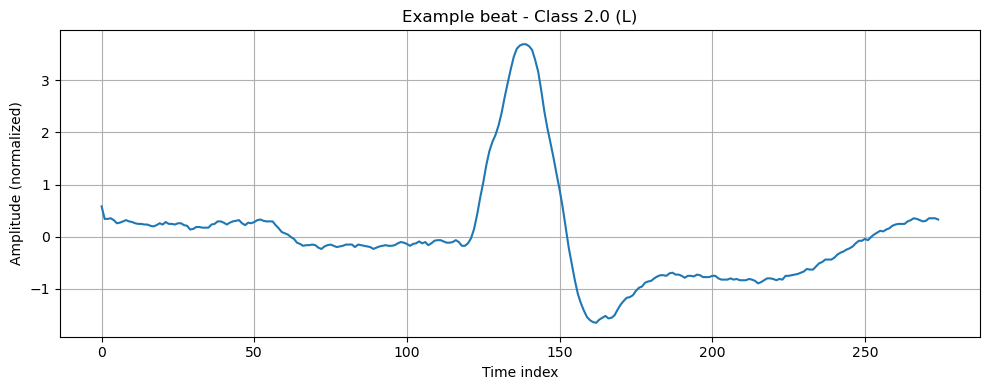

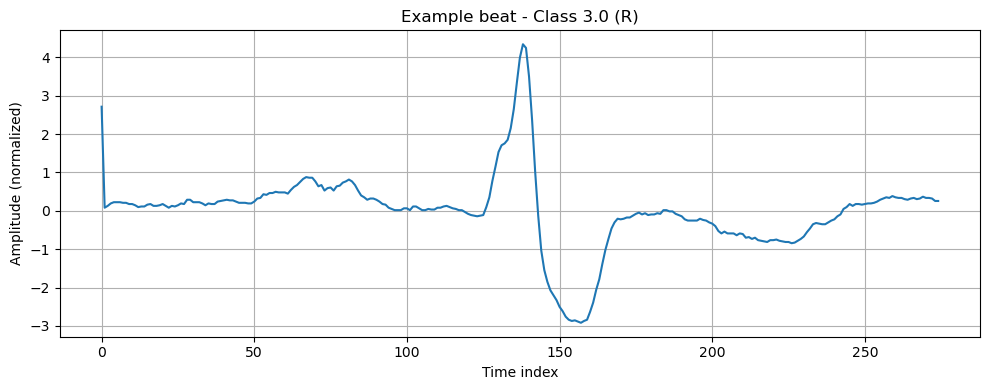

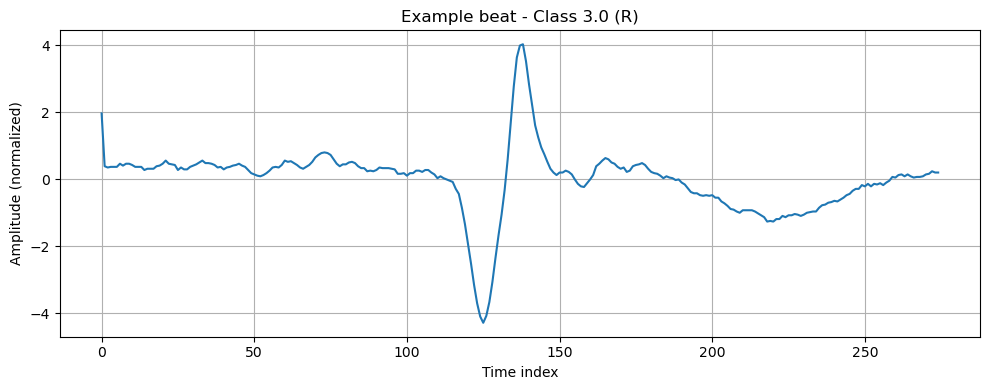

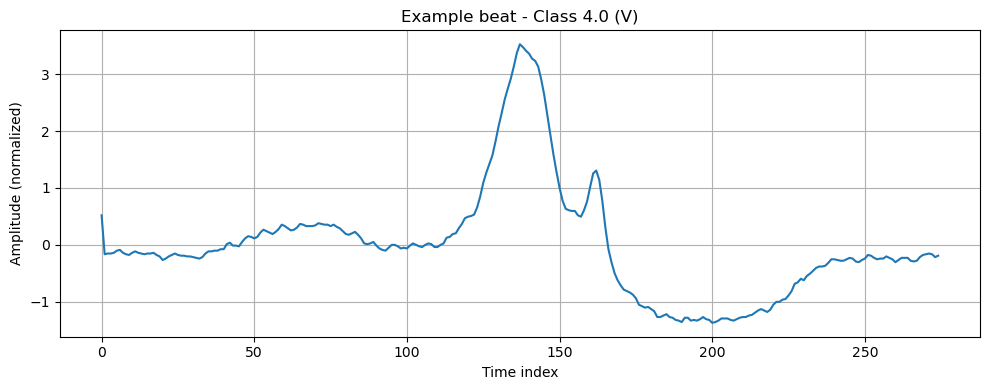

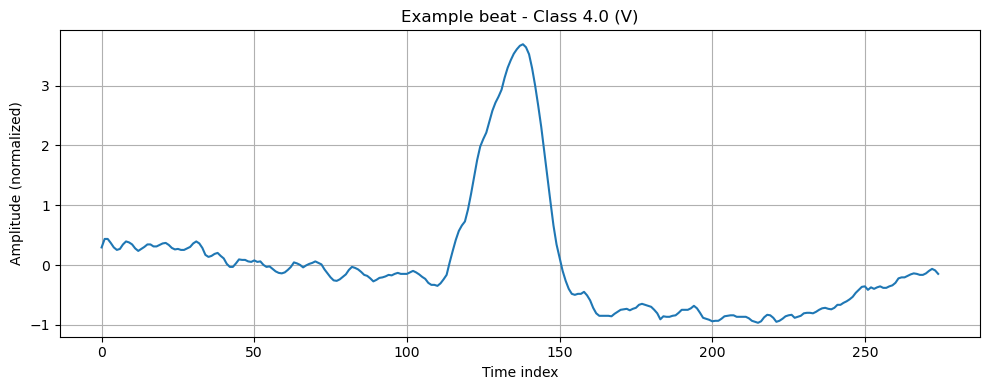

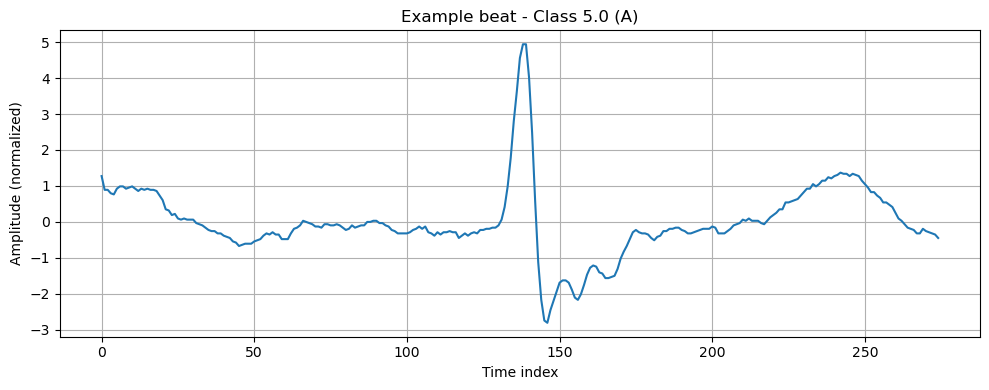

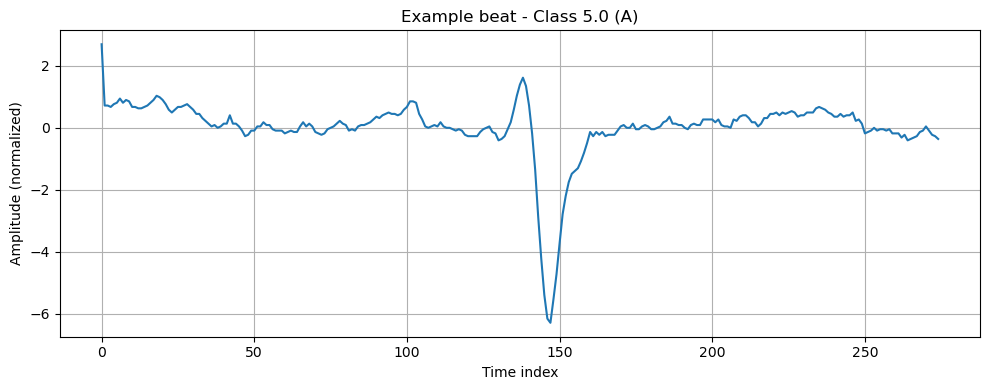

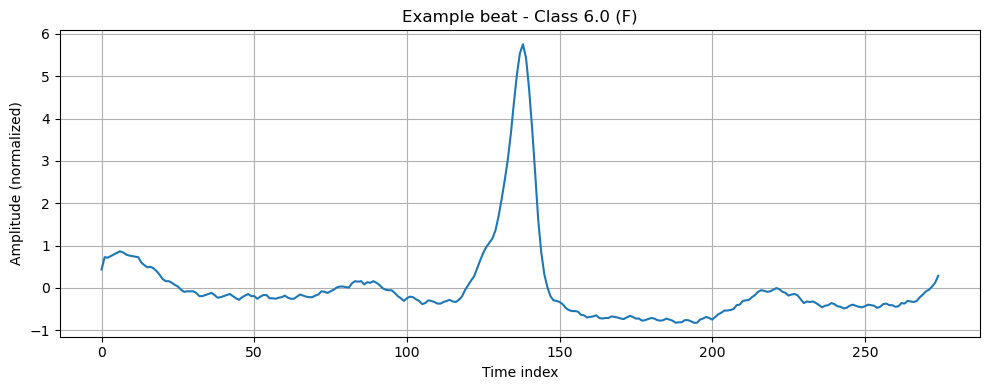

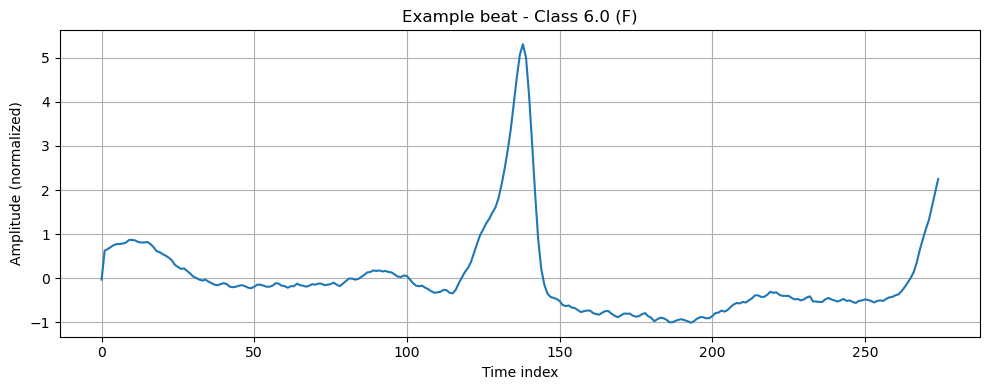

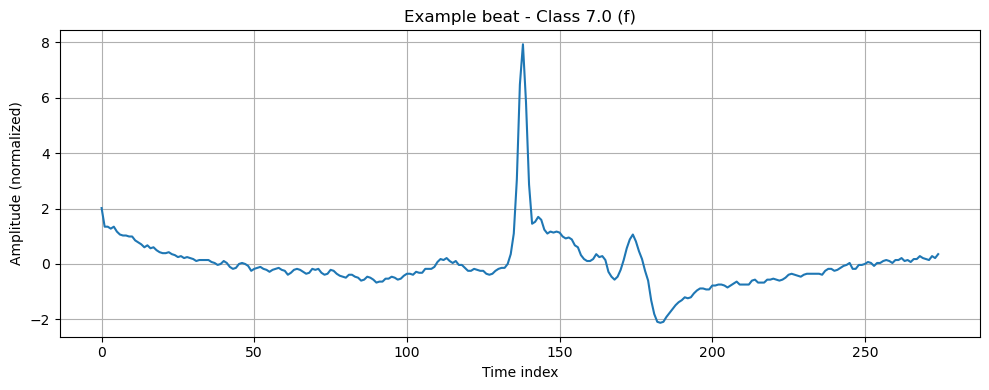

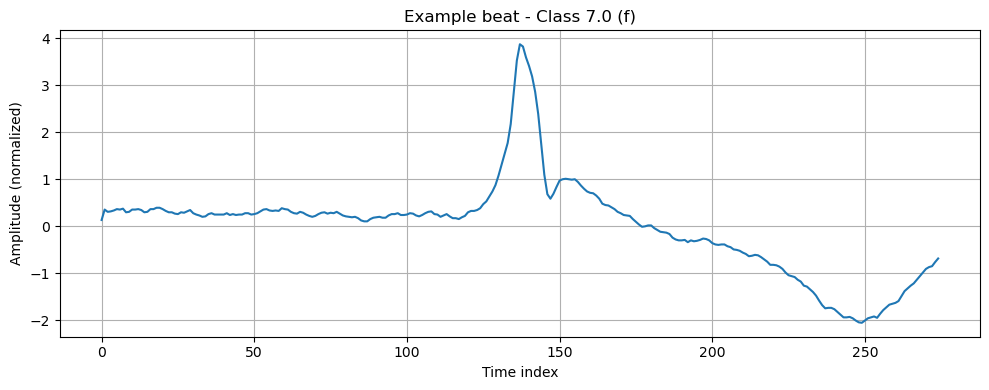

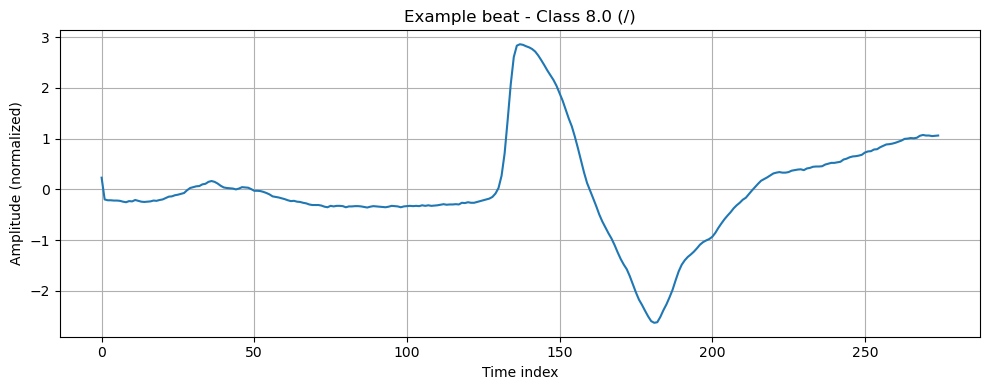

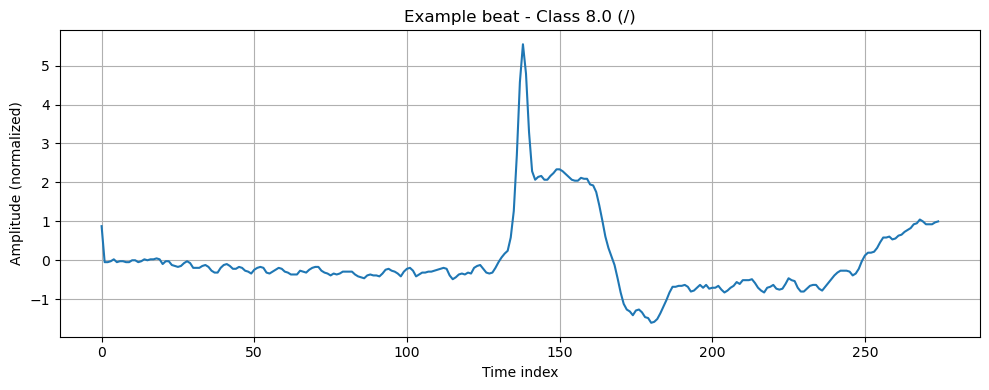

In [4]:
def plot_examples_per_class(X, y, n_per_class=2):
    unique_classes = np.unique(y)
    for cls in unique_classes:
        idx = np.where(y == cls)[0][:n_per_class]
        if len(idx) == 0:
            continue
        
        label_name = id_to_label.get(int(cls), str(cls))
        for i in idx:
            plt.figure()
            plt.plot(X[i])
            plt.title(f"Example beat - Class {cls} ({label_name})")
            plt.xlabel("Time index")
            plt.ylabel("Amplitude (normalized)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

plot_examples_per_class(X_train, y_train, n_per_class=2)


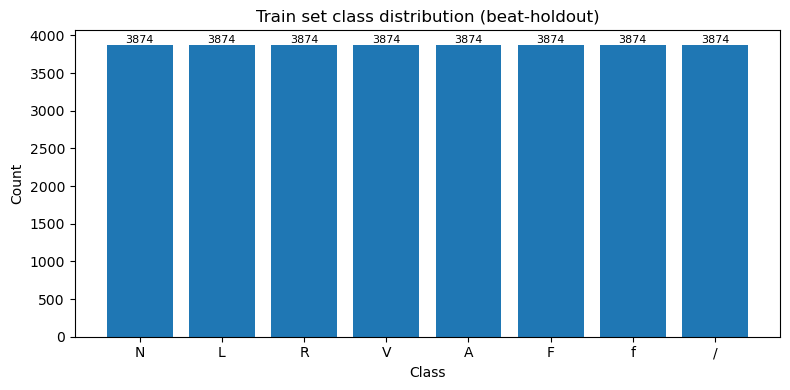

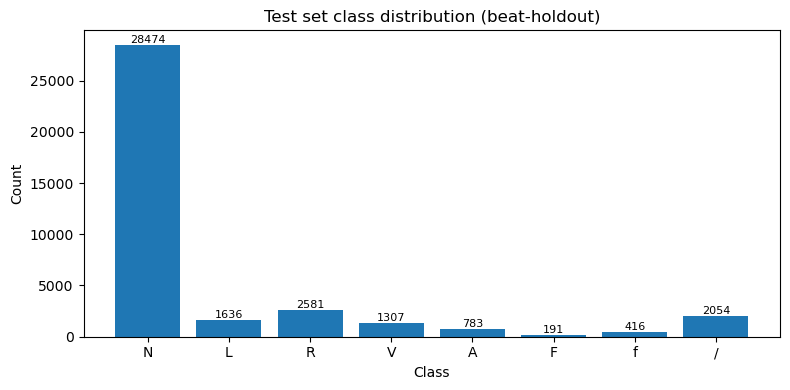

In [5]:
def plot_class_distribution(y, title="Class distribution"):
    labels, counts = np.unique(y, return_counts=True)
    label_names = [id_to_label.get(int(l), str(l)) for l in labels]
    
    plt.figure(figsize=(8,4))
    plt.bar(label_names, counts)
    for i, c in enumerate(counts):
        plt.text(i, c, str(c), ha="center", va="bottom", fontsize=8)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_class_distribution(y_train, "Train set class distribution (beat-holdout)")
plot_class_distribution(y_test,  "Test set class distribution (beat-holdout)")


In [6]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# SVM pipeline: standardize features + RBF SVM
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", decision_function_shape="ovr"))
])

# Train on beat-holdout TRAIN set
svm_clf.fit(X_train, y_train)

print("SVM training finished.")


SVM training finished.


In [7]:
# Predict on test set
y_pred = svm_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (beat-holdout test set): {acc:.4f}")

# Precision, Recall, F1 per class (macro average is best for imbalanced data)
prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=np.unique(y_test))

for cls, p, r, f, s in zip(np.unique(y_test), prec, rec, f1, support):
    print(f"Class {int(cls)} -> Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, Support: {s}")

print("\nMacro-averaged metrics:")
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro"
)
print(f"Precision (macro): {prec_macro:.3f}")
print(f"Recall (macro):    {rec_macro:.3f}")
print(f"F1-score (macro):  {f1_macro:.3f}")

# Optional: full sklearn report
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

Accuracy (beat-holdout test set): 0.9494
Class 1 -> Precision: 0.996, Recall: 0.941, F1: 0.968, Support: 28474
Class 2 -> Precision: 0.990, Recall: 0.996, F1: 0.993, Support: 1636
Class 3 -> Precision: 0.996, Recall: 0.988, F1: 0.992, Support: 2581
Class 4 -> Precision: 0.779, Recall: 0.953, F1: 0.858, Support: 1307
Class 5 -> Precision: 0.568, Recall: 0.911, F1: 0.699, Support: 783
Class 6 -> Precision: 0.200, Recall: 0.937, F1: 0.330, Support: 191
Class 7 -> Precision: 0.733, Recall: 0.942, F1: 0.824, Support: 416
Class 8 -> Precision: 0.993, Recall: 0.992, F1: 0.992, Support: 2054

Macro-averaged metrics:
Precision (macro): 0.782
Recall (macro):    0.958
F1-score (macro):  0.832

Classification report:

              precision    recall  f1-score   support

         1.0       1.00      0.94      0.97     28474
         2.0       0.99      1.00      0.99      1636
         3.0       1.00      0.99      0.99      2581
         4.0       0.78      0.95      0.86      1307
         5.0 

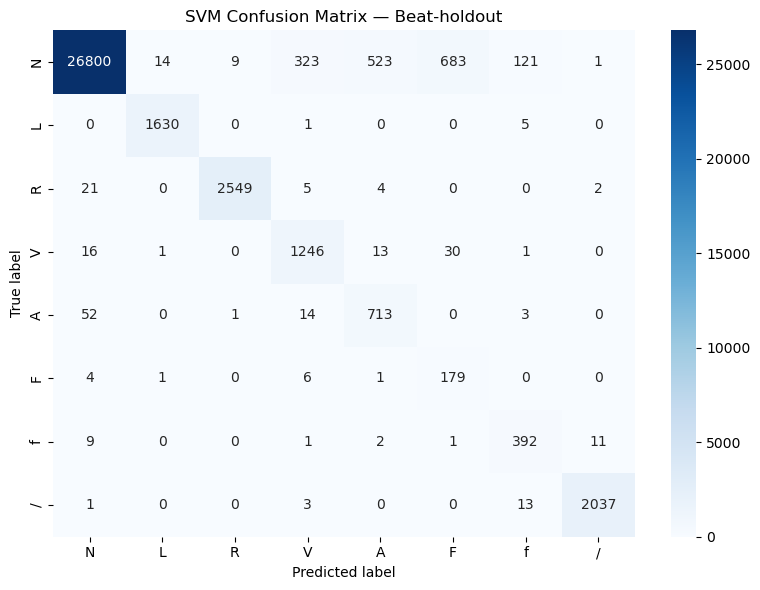

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Map IDs to labels (reuse your id_to_label dict)
labels = np.unique(y_test)
tick_labels = [id_to_label[int(l)] for l in labels]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=tick_labels, yticklabels=tick_labels,
            cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("SVM Confusion Matrix — Beat-holdout")
plt.tight_layout()
plt.show()

In [9]:
# ---- STEP 3: SVM with patient-holdout split ----

patient_train_path = "train_patients.csv"   # change to your actual file name
patient_test_path  = "test_patients.csv"    # change to your actual file name

patient_train_df = pd.read_csv(patient_train_path, header=None)
patient_test_df  = pd.read_csv(patient_test_path, header=None)

print("Patient-holdout Train shape:", patient_train_df.shape)
print("Patient-holdout Test shape :", patient_test_df.shape)
patient_train_df.head()


Patient-holdout Train shape: (200352, 277)
Patient-holdout Test shape : (14482, 277)


,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,0.206254,0.627582,0.627582,0.593420,0.616195,0.582033,0.593420,0.547871,0.468161,0.445386,...,-0.397270,-0.340334,-0.283397,-0.226461,-0.237848,-0.260623,-0.283397,-0.215074,7.0,217.0
1,1.705043,0.085257,0.140165,0.222527,0.167619,0.085257,0.002895,0.030349,0.057803,0.140165,...,0.908877,0.991239,0.908877,0.881423,0.881423,0.908877,1.046147,1.018693,8.0,104.0
2,0.633639,-0.092466,-0.106988,-0.106988,-0.092466,-0.048900,-0.121510,-0.106988,-0.136033,-0.106988,...,-0.048900,-0.063422,-0.077944,-0.121510,-0.136033,-0.121510,-0.063422,-0.034378,2.0,214.0
3,1.387253,-0.600657,-0.582250,-0.655876,-0.655876,-0.619063,-0.637470,-0.619063,-0.582250,-0.582250,...,-0.306151,-0.306151,-0.306151,-0.287745,-0.361371,-0.361371,-0.342965,-0.416591,1.0,117.0
4,0.094505,-0.090508,-0.095949,-0.106832,-0.112274,-0.106832,-0.123157,-0.144923,-0.150365,-0.139481,...,1.329734,1.324292,1.291643,1.253552,1.226344,1.193695,1.177371,1.177371,8.0,107.0


In [11]:
X_train_p, y_train_p, pid_train_p = split_xy(patient_train_df)
X_test_p,  y_test_p,  pid_test_p  = split_xy(patient_test_df)

print("X_train_p shape:", X_train_p.shape)
print("y_train_p shape:", y_train_p.shape)
print("Unique labels in patient-train:", np.unique(y_train_p))
print("Unique labels in patient-test :", np.unique(y_test_p))


X_train_p shape: (200352, 275)
y_train_p shape: (200352,)
Unique labels in patient-train: [1. 2. 3. 4. 5. 6. 7. 8.]
Unique labels in patient-test : [1. 4. 6. 7. 8.]


In [12]:
svm_clf_patient = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", decision_function_shape="ovr"))
])

svm_clf_patient.fit(X_train_p, y_train_p)
print("SVM (patient-holdout) training finished.")


SVM (patient-holdout) training finished.


In [13]:
y_pred_p = svm_clf_patient.predict(X_test_p)

acc_p = accuracy_score(y_test_p, y_pred_p)
print(f"Accuracy (patient-holdout test set): {acc_p:.4f}")

prec_p, rec_p, f1_p, support_p = precision_recall_fscore_support(
    y_test_p, y_pred_p, labels=np.unique(y_test_p)
)

for cls, p, r, f, s in zip(np.unique(y_test_p), prec_p, rec_p, f1_p, support_p):
    print(f"Class {int(cls)} -> Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, Support: {s}")

print("\nMacro-averaged metrics (patient-holdout):")
prec_macro_p, rec_macro_p, f1_macro_p, _ = precision_recall_fscore_support(
    y_test_p, y_pred_p, average="macro"
)
print(f"Precision (macro): {prec_macro_p:.3f}")
print(f"Recall (macro):    {rec_macro_p:.3f}")
print(f"F1-score (macro):  {f1_macro_p:.3f}")

print("\nClassification report (patient-holdout):\n")
print(classification_report(y_test_p, y_pred_p))


Accuracy (patient-holdout test set): 0.9735
Class 1 -> Precision: 1.000, Recall: 0.964, F1: 0.982, Support: 9363
Class 4 -> Precision: 0.975, Recall: 0.985, F1: 0.980, Support: 1087
Class 6 -> Precision: 0.758, Recall: 0.997, F1: 0.862, Support: 387
Class 7 -> Precision: 0.854, Recall: 0.995, F1: 0.919, Support: 1138
Class 8 -> Precision: 0.998, Recall: 0.990, F1: 0.994, Support: 2507

Macro-averaged metrics (patient-holdout):
Precision (macro): 0.655
Recall (macro):    0.704
F1-score (macro):  0.677

Classification report (patient-holdout):

              precision    recall  f1-score   support

         1.0       1.00      0.96      0.98      9363
         3.0       0.00      0.00      0.00         0
         4.0       0.98      0.99      0.98      1087
         5.0       0.00      0.00      0.00         0
         6.0       0.76      1.00      0.86       387
         7.0       0.85      0.99      0.92      1138
         8.0       1.00      0.99      0.99      2507

    accuracy     

C:\Users\keert\.conda\envs\mynew\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\keert\.conda\envs\mynew\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\keert\.conda\envs\mynew\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\keert\.conda\envs\m

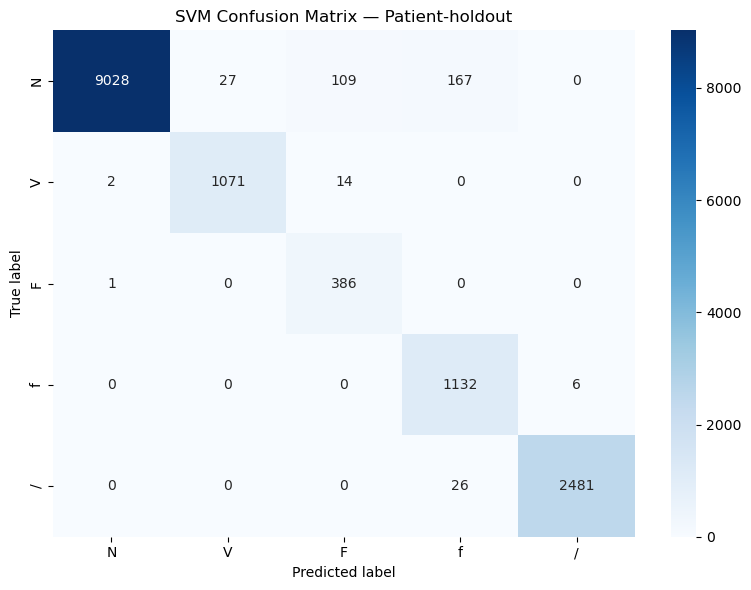

In [14]:
cm_p = confusion_matrix(y_test_p, y_pred_p, labels=np.unique(y_test_p))

labels_p = np.unique(y_test_p)
tick_labels_p = [id_to_label[int(l)] for l in labels_p]

plt.figure(figsize=(8,6))
sns.heatmap(cm_p, annot=True, fmt="d",
            xticklabels=tick_labels_p, yticklabels=tick_labels_p,
            cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("SVM Confusion Matrix — Patient-holdout")
plt.tight_layout()
plt.show()


In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def get_slice_indices(n_features=275, n_slices=11):
    """Return list of (start, end) indices for each slice."""
    slice_size = n_features // n_slices  # 275 // 11 = 25
    indices = []
    for s in range(n_slices):
        start = s * slice_size
        end = (s + 1) * slice_size   # end is exclusive
        indices.append((start, end))
    return indices

slice_indices = get_slice_indices(275, 11)
slice_indices


[(0, 25),
 (25, 50),
 (50, 75),
 (75, 100),
 (100, 125),
 (125, 150),
 (150, 175),
 (175, 200),
 (200, 225),
 (225, 250),
 (250, 275)]

In [17]:
def pfi_slices_svm(
    X, y,
    n_slices=11,
    n_splits=3,
    random_state=42,
    max_samples=None
):
    """
    Permutation Feature Importance using 11 slices and Stratified K-fold CV.
    Returns: mean importance per slice (length = n_slices).
    """
    rng = np.random.RandomState(random_state)
    
    # Optionally subsample for speed
    if max_samples is not None and X.shape[0] > max_samples:
        from sklearn.utils import resample
        X, y = resample(
            X, y,
            n_samples=max_samples,
            replace=False,
            random_state=random_state
        )
        print(f"Subsampled to {max_samples} samples for PFI.")
    
    n_features = X.shape[1]
    slice_indices = get_slice_indices(n_features, n_slices)
    
    # K-fold CV
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )
    
    # store importance per slice per fold
    importances = np.zeros((n_slices, n_splits))
    
    fold_idx = 0
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        # fresh SVM for each fold
        svm = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", decision_function_shape="ovr"))
        ])
        svm.fit(X_tr, y_tr)
        
        # baseline score
        y_pred_base = svm.predict(X_val)
        base_score = accuracy_score(y_val, y_pred_base)
        
        print(f"Fold {fold_idx+1}/{n_splits} - baseline accuracy: {base_score:.4f}")
        
        # for each slice: permute slice in validation data, measure drop
        for s_idx, (start, end) in enumerate(slice_indices):
            X_val_perm = X_val.copy()
            
            # permute this slice (randomly shuffle rows within slice)
            # we permute *within* the slice across samples
            perm_indices = rng.permutation(X_val_perm.shape[0])
            X_val_perm[:, start:end] = X_val_perm[perm_indices, start:end]
            
            y_pred_perm = svm.predict(X_val_perm)
            perm_score = accuracy_score(y_val, y_pred_perm)
            
            importances[s_idx, fold_idx] = base_score - perm_score
        
        fold_idx += 1
    
    # average over folds
    mean_importance = importances.mean(axis=1)
    return mean_importance


Subsampled to 15000 samples for PFI.
Fold 1/3 - baseline accuracy: 0.9536
Fold 2/3 - baseline accuracy: 0.9508
Fold 3/3 - baseline accuracy: 0.9528
Beat-holdout slice importances:
 [0.0612     0.05193333 0.077      0.12293333 0.08406667 0.1638
 0.17093333 0.12       0.0954     0.09326667 0.04493333]


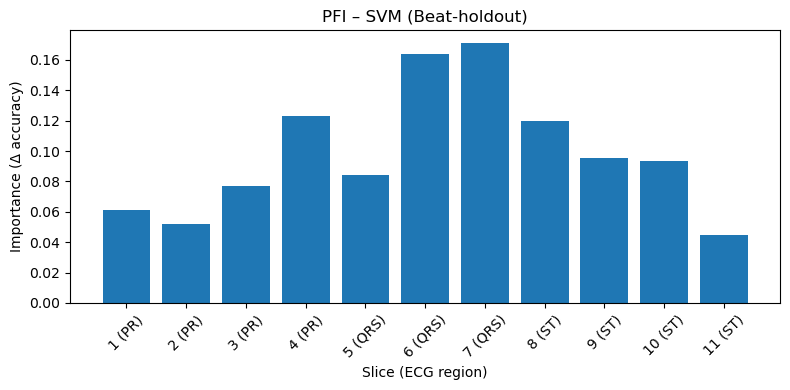

In [18]:
pfi_beat = pfi_slices_svm(
    X_train, y_train,
    n_slices=11,
    n_splits=3,      # change to 5 if you have time
    max_samples=15000   # reduce or increase depending on your machine
)

print("Beat-holdout slice importances:\n", pfi_beat)
# Map slices to ECG segments (as in slides)
slice_labels = [
    "1 (PR)", "2 (PR)", "3 (PR)", "4 (PR)",
    "5 (QRS)", "6 (QRS)", "7 (QRS)",
    "8 (ST)", "9 (ST)", "10 (ST)", "11 (ST)"
]

plt.figure(figsize=(8,4))
plt.bar(range(1, 12), pfi_beat)
plt.xticks(range(1, 12), slice_labels, rotation=45)
plt.xlabel("Slice (ECG region)")
plt.ylabel("Importance (Δ accuracy)")
plt.title("PFI – SVM (Beat-holdout)")
plt.tight_layout()
plt.show()


Subsampled to 15000 samples for PFI.
Fold 1/3 - baseline accuracy: 0.9530
Fold 2/3 - baseline accuracy: 0.9494
Fold 3/3 - baseline accuracy: 0.9536
Patient-holdout slice importances:
 [0.05733333 0.04333333 0.06993333 0.1248     0.08613333 0.1608
 0.16733333 0.10026667 0.08593333 0.09206667 0.04853333]


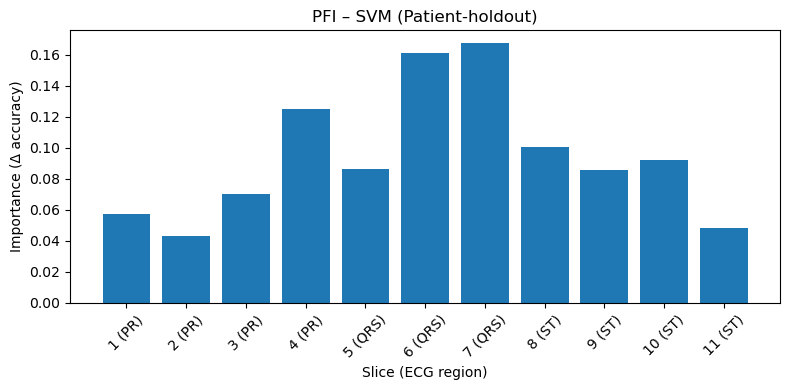

In [19]:
pfi_patient = pfi_slices_svm(
    X_train_p, y_train_p,
    n_slices=11,
    n_splits=3,
    max_samples=15000
)

print("Patient-holdout slice importances:\n", pfi_patient)
plt.figure(figsize=(8,4))
plt.bar(range(1, 12), pfi_patient)
plt.xticks(range(1, 12), slice_labels, rotation=45)
plt.xlabel("Slice (ECG region)")
plt.ylabel("Importance (Δ accuracy)")
plt.title("PFI – SVM (Patient-holdout)")
plt.tight_layout()
plt.show()

RF Accuracy (beat-holdout): 0.9694

RF classification report (beat-holdout):
              precision    recall  f1-score   support

         1.0       1.00      0.97      0.98     28474
         2.0       0.99      1.00      0.99      1636
         3.0       0.99      0.99      0.99      2581
         4.0       0.76      0.97      0.85      1307
         5.0       0.63      0.90      0.75       783
         6.0       0.62      0.90      0.73       191
         7.0       0.85      0.93      0.89       416
         8.0       0.99      0.99      0.99      2054

    accuracy                           0.97     37442
   macro avg       0.85      0.96      0.90     37442
weighted avg       0.98      0.97      0.97     37442



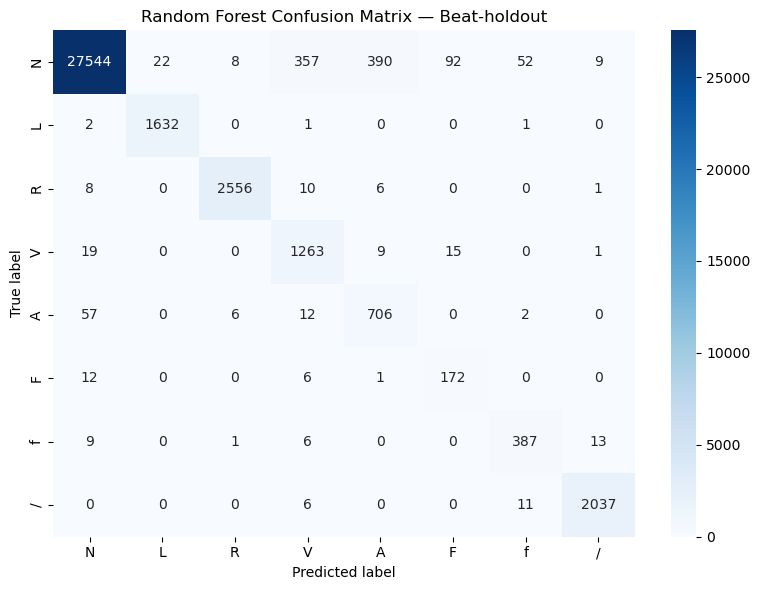

In [20]:
from sklearn.ensemble import RandomForestClassifier

# RF on beat-holdout data
rf_beat = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf_beat.fit(X_train, y_train)
y_pred_rf_beat = rf_beat.predict(X_test)

acc_rf_beat = accuracy_score(y_test, y_pred_rf_beat)
print(f"RF Accuracy (beat-holdout): {acc_rf_beat:.4f}")

print("\nRF classification report (beat-holdout):")
print(classification_report(y_test, y_pred_rf_beat))

cm_rf_beat = confusion_matrix(y_test, y_pred_rf_beat, labels=np.unique(y_test))
tick_labels = [id_to_label[int(l)] for l in np.unique(y_test)]

plt.figure(figsize=(8,6))
sns.heatmap(cm_rf_beat, annot=True, fmt="d",
            xticklabels=tick_labels, yticklabels=tick_labels,
            cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Random Forest Confusion Matrix — Beat-holdout")
plt.tight_layout()
plt.show()

In [21]:
def pfi_slices_model(
    X, y, model_builder,
    n_slices=11,
    n_splits=3,
    random_state=42,
    max_samples=None
):
    rng = np.random.RandomState(random_state)

    if max_samples is not None and X.shape[0] > max_samples:
        from sklearn.utils import resample
        X, y = resample(X, y, n_samples=max_samples,
                        replace=False, random_state=random_state)
        print(f"Subsampled to {max_samples} samples for PFI.")

    n_features = X.shape[1]
    slice_indices = get_slice_indices(n_features, n_slices)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    importances = np.zeros((n_slices, n_splits))

    fold_idx = 0
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = model_builder()
        model.fit(X_tr, y_tr)
        base_score = accuracy_score(y_val, model.predict(X_val))

        for s_idx, (start, end) in enumerate(slice_indices):
            X_val_perm = X_val.copy()
            perm_idx = rng.permutation(X_val_perm.shape[0])
            X_val_perm[:, start:end] = X_val_perm[perm_idx, start:end]
            perm_score = accuracy_score(y_val, model.predict(X_val_perm))
            importances[s_idx, fold_idx] = base_score - perm_score

        fold_idx += 1

    return importances.mean(axis=1)

Subsampled to 15000 samples for PFI.


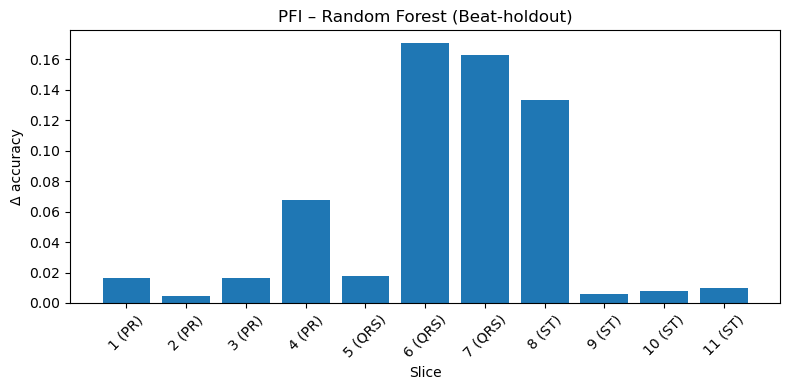

In [22]:
# PFI for RF beat-holdout
def build_rf_beat():
    return RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )

pfi_rf_beat = pfi_slices_model(
    X_train, y_train,
    model_builder=build_rf_beat,
    n_slices=11,
    n_splits=3,
    max_samples=15000
)

plt.figure(figsize=(8,4))
plt.bar(range(1,12), pfi_rf_beat)
plt.xticks(range(1,12), slice_labels, rotation=45)
plt.title("PFI – Random Forest (Beat-holdout)")
plt.xlabel("Slice")
plt.ylabel("Δ accuracy")
plt.tight_layout()
plt.show()

Subsampled to 15000 samples for PFI.


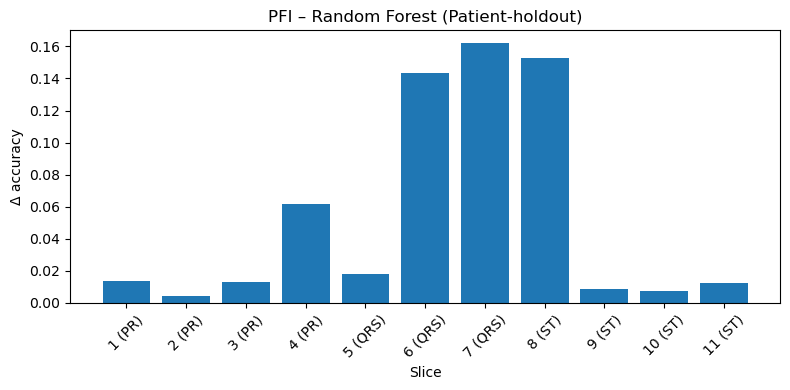

In [23]:
def build_rf_patient():
    return RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )

pfi_rf_patient = pfi_slices_model(
    X_train_p, y_train_p,
    model_builder=build_rf_patient,
    n_slices=11,
    n_splits=3,
    max_samples=15000
)

plt.figure(figsize=(8,4))
plt.bar(range(1,12), pfi_rf_patient)
plt.xticks(range(1,12), slice_labels, rotation=45)
plt.title("PFI – Random Forest (Patient-holdout)")
plt.xlabel("Slice")
plt.ylabel("Δ accuracy")
plt.tight_layout()
plt.show()